# Statistical Methods for Machine Learning project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
if 'google.colab' in str(get_ipython()):
    COLAB = True
else:
    COLAB = False

In [3]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
print("Path to dataset files:", path)

100%|██████████| 306M/306M [00:08<00:00, 38.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


(200, 300, 3)


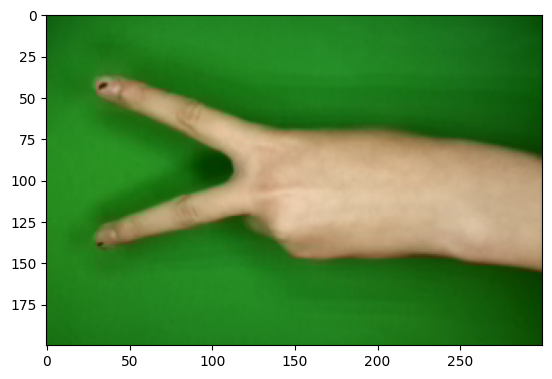

In [4]:
plt.figure()
folder = os.path.join(path, random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Creation of training and validation folders

In [5]:
# creation of training and validation folders
ratio = 0.8
subfolders = ['rock','paper','scissors']

os.makedirs('train', exist_ok=True)
os.makedirs('val', exist_ok=True)
for subfolder in subfolders:
    subpath = os.path.join(path, subfolder)
    os.makedirs(os.path.join('train',subfolder))
    os.makedirs(os.path.join('val',subfolder))

    imgs = os.listdir(subpath)
    random.shuffle(imgs)

    train_size = int(0.8 * len(imgs))
    val_size = len(imgs) - train_size

    train_imgs = imgs[:train_size]
    val_imgs = imgs[train_size:]

    for i in train_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
    for i in val_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('val',subfolder,i))




# Transformation and data augmentation

In [6]:
# no need to resize since all images have the same dimension (?)
# validation set only transformed to tensor
# training set augmented with random transformations

val_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-20,20)),
])

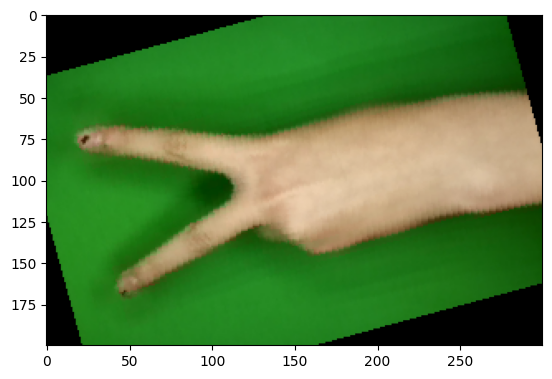

In [7]:
transformed_img = train_transform(img)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

# DataLoader creation

In [8]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='val', transform=val_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size)

classes = train_dataset.classes

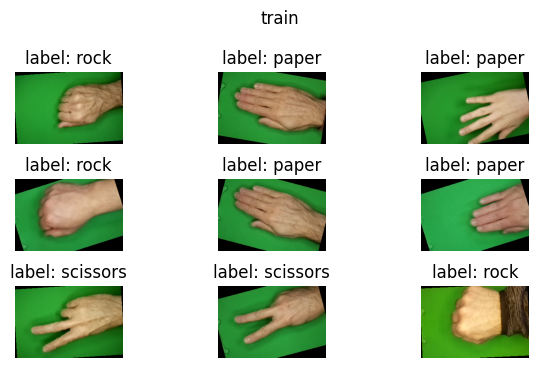

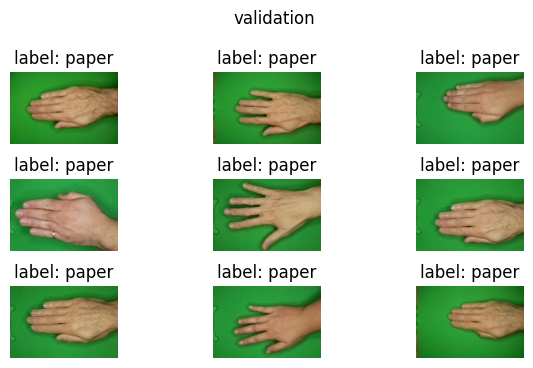

In [9]:
def show_batch(x, y, yh=None, title=None):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        subtitle = 'label: ' + classes[int(y[i])]
        if (yh is not None):
            subtitle += '\nprediction: ' + classes[int(np.argmax(yh[i]))]
        ax.set_title(subtitle)
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(val_dl)), title='validation')

# SomeNet

In [10]:
class SomeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6,16,3)
        self.middleconv2 = nn.Conv2d(16,16,3)
        self.norm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,64,3)
        self.norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,120,3)
        self.middleconv4 = nn.Conv2d(120,120,3)
        self.norm4 = nn.BatchNorm2d(120)

        self.fc1 = nn.Linear(162*10*10,120)
        self.fc2 = nn.Linear(120,64)
        self.fc3 = nn.Linear(64,3)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool(F.relu(self.norm2(self.middleconv2(x))))
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.middleconv4(x)))

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = SomeNet()
net.to(device)

img,lbl=next(iter(train_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])
Size of the output tensor is torch.Size([9, 3])


In [12]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    classes = dataloaders['train'].dataset.classes
    numClasses = len(classes)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 1000000
    best_aucs = np.array([best_auc, best_auc])

    train_loss_time = []
    val_loss_time = []

    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for img,lbl in dataloaders[phase]:
                inputs = img.to(device).float()
                labels = lbl.to(device)


                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batch_size,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batch_size]=labels.cpu().numpy()
                contSamples+=batch_size

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
                train_loss_time.append(epoch_loss)
            else:
                val_loss_time.append(epoch_loss)

            #Compute the AUCs at the end of the epoch
            aucs=np.array([epoch_loss,epoch_loss])#computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc < best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    plt.plot(train_loss_time, 'bo-', label='train loss')
    plt.plot(val_loss_time, 'r+-', label='val loss')
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/19
----------
train Loss: 0.5361 AUC mel: 0.5361 sk: 0.5361 avg: 0.5361
val Loss: 0.3965 AUC mel: 0.3965 sk: 0.3965 avg: 0.3965

Epoch 1/19
----------
train Loss: 0.1862 AUC mel: 0.1862 sk: 0.1862 avg: 0.1862
val Loss: 0.1627 AUC mel: 0.1627 sk: 0.1627 avg: 0.1627

Epoch 2/19
----------
train Loss: 0.1213 AUC mel: 0.1213 sk: 0.1213 avg: 0.1213
val Loss: 0.2725 AUC mel: 0.2725 sk: 0.2725 avg: 0.2725

Epoch 3/19
----------
train Loss: 0.0990 AUC mel: 0.0990 sk: 0.0990 avg: 0.0990
val Loss: 0.1024 AUC mel: 0.1024 sk: 0.1024 avg: 0.1024

Epoch 4/19
----------
train Loss: 0.0688 AUC mel: 0.0688 sk: 0.0688 avg: 0.0688
val Loss: 0.1378 AUC mel: 0.1378 sk: 0.1378 avg: 0.1378

Epoch 5/19
----------
train Loss: 0.0493 AUC mel: 0.0493 sk: 0.0493 avg: 0.0493
val Loss: 0.1250 AUC mel: 0.1250 sk: 0.1250 avg: 0.1250

Epoch 6/19
----------
train Loss: 0.0579 AUC mel: 0.0579 sk: 0.0579 avg: 0.0579
val Loss: 0.1232 AUC mel: 0.1232 sk: 0.1232 avg: 0.1232

Epoch 7/19
----------
train Loss: 0.0262 

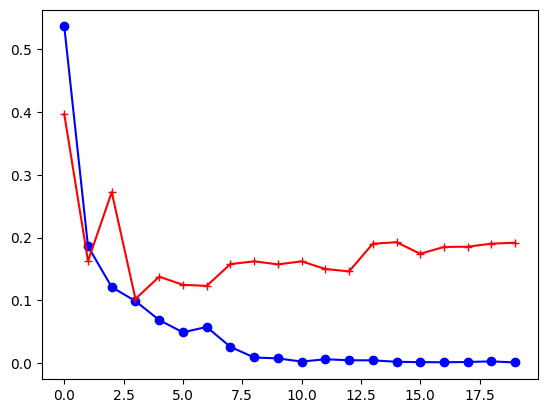

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


image_datasets = {'train' : train_dataset, 'val': val_dataset}

dls = {'train' : train_dl, 'val': val_dl}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
net = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


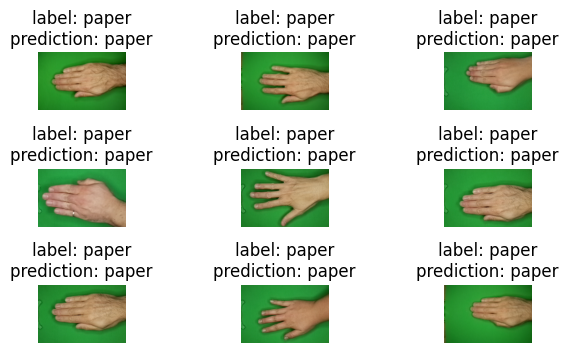

In [14]:
img,lbl=next(iter(val_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)




if (device=='cpu'):
    show_batch(img,lbl,outputs)
else:
    show_batch(img,lbl,outputs.cpu().numpy())



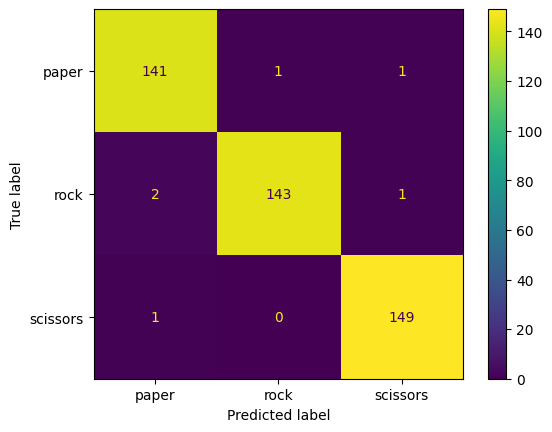

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y = []
y_hat = []

with torch.set_grad_enabled(False):
    for img, lbls in val_dl:
        output = net(img.to(device).float()).to('cpu').float()
        y.extend(lbls)
        pred = output.data.max(1, keepdim=True)[1]
        y_hat.extend(pred)

cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
ConfusionMatrixDisplay(cm,display_labels=classes).plot()

In [16]:
print(classes)

['paper', 'rock', 'scissors']


In [17]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 39.0 MB/s eta 0:00:00


In [20]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall

def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25):
    stats = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
            'val_rec': [],
            'val_prec': []
    }
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # TRAIN
        running_loss = 0
        for batch_index, (images, labels) in enumerate(tqdm(dataloaders['train'])):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()

        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)
        # VAL
        # Set up of multiclass accuracy metric
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        # Iterate over the dataset batches
        model.eval()
        with torch.no_grad():
            for images, labels in dataloaders['val']: # Changed 'test' to 'val' based on existing dataloaders
                images = images.to(device)
                labels = labels.to(device)
                # Get predicted probabilities for test data batch
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            val_loss = running_loss / len(dataloaders['val'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()

            stats['val_loss'].append(val_loss)
            stats['val_acc'].append(test_accuracy.to('cpu'))
            stats['val_rec'].append(test_recall.to('cpu'))
            stats['val_prec'].append(test_precision.to('cpu'))


        print(f"Train loss: {epoch_loss:.4f}")
        print(f"Test loss: {val_loss:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test precision: {test_precision:.4f}")
        print(f"Test recall: {test_recall:.4f}")

    plt.plot(stats['train_loss'], 'bo-', label='train loss')
    plt.plot(stats['val_loss'], 'r+-', label='val loss')
    plt.show()

    plt.plot(stats['val_acc'])
    plt.plot(stats['val_rec'])
    plt.plot(stats['val_prec'])
    plt.show()

Epoch 0/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.73it/s]


Train loss: 0.1505
Test loss: 1.0037
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 1/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.65it/s]


Train loss: 0.1093
Test loss: 0.7864
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 2/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.74it/s]


Train loss: 0.1309
Test loss: 0.8646
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 3/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.60it/s]


Train loss: 0.1815
Test loss: 1.0741
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 4/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.38it/s]


Train loss: 0.0785
Test loss: 0.6529
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 5/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.73it/s]


Train loss: 0.0764
Test loss: 0.6566
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 6/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.61it/s]


Train loss: 0.1279
Test loss: 0.8562
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 7/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.02it/s]


Train loss: 0.0829
Test loss: 0.6516
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 8/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.93it/s]


Train loss: 0.1032
Test loss: 0.7590
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 9/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.46it/s]


Train loss: 0.0665
Test loss: 0.5894
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 10/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.04it/s]


Train loss: 0.0615
Test loss: 0.5656
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 11/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.84it/s]


Train loss: 0.0455
Test loss: 0.5220
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 12/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.94it/s]


Train loss: 0.0628
Test loss: 0.5698
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 13/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.06it/s]


Train loss: 0.0908
Test loss: 0.6728
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 14/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.92it/s]


Train loss: 0.0367
Test loss: 0.4488
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9863
Epoch 15/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.15it/s]


Train loss: 0.0925
Test loss: 0.6982
Test accuracy: 0.9886
Test precision: 0.9887
Test recall: 0.9886
Epoch 16/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.07it/s]


Train loss: 0.0796
Test loss: 0.6148
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9863
Epoch 17/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.71it/s]


Train loss: 0.0621
Test loss: 0.5601
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9863
Epoch 18/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.09it/s]


Train loss: 0.0367
Test loss: 0.4329
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 19/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.14it/s]


Train loss: 0.0752
Test loss: 0.6165
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 20/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.84it/s]


Train loss: 0.0352
Test loss: 0.4295
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9863
Epoch 21/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.04it/s]


Train loss: 0.0322
Test loss: 0.4397
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 22/29
----------


100%|██████████| 195/195 [00:14<00:00, 13.02it/s]


Train loss: 0.0354
Test loss: 0.4147
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9863
Epoch 23/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.98it/s]


Train loss: 0.0272
Test loss: 0.3893
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 24/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.86it/s]


Train loss: 0.0807
Test loss: 0.6240
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 25/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.27it/s]


Train loss: 0.0307
Test loss: 0.4216
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 26/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.77it/s]


Train loss: 0.0515
Test loss: 0.4899
Test accuracy: 0.9841
Test precision: 0.9840
Test recall: 0.9840
Epoch 27/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.97it/s]


Train loss: 0.0420
Test loss: 0.4538
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9864
Epoch 28/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.63it/s]


Train loss: 0.0289
Test loss: 0.3813
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9863
Epoch 29/29
----------


100%|██████████| 195/195 [00:15<00:00, 12.64it/s]


Train loss: 0.0235
Test loss: 0.3661
Test accuracy: 0.9863
Test precision: 0.9863
Test recall: 0.9863


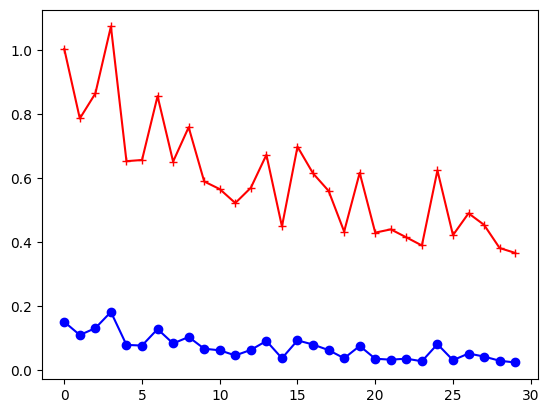

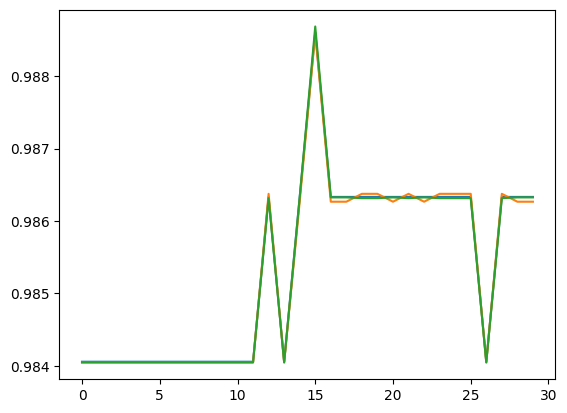

In [22]:
train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)